In [ ]:
# Step 1: Install dependencies (only once per Colab session)
!pip install transformers torch scikit-learn tqdm

In [ ]:
# Step 2: Imports
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pandas as pd

# Step 3: Load dataset
# Make sure you uploaded fake_news_preprocessed.csv to Colab or Google Drive
df = pd.read_csv("fake_news_preprocessed.csv")

# Example: assume your CSV has 'text' and 'label' columns
X = df['text'].astype(str).values
y = df['label'].values

# Step 4: Encode labels (convert FAKE/REAL -> 0/1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Step 7: Custom Dataset class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))  # ensure integer
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)

# Step 8: Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Step 9: Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(set(y)))
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
import numpy as np
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import torch

# =========================
# Compute class weights
# =========================
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", weights)

loss_fn = CrossEntropyLoss(weight=weights)

# =========================
# Optimizer + scheduler
# =========================
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
num_epochs = 5
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# =========================
# Training Loop
# =========================
epoch_losses = []
epoch_accuracies = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        loop.set_postfix(batch_loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    accuracy = correct / total
    epoch_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} -> Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# =========================
# Evaluation
# =========================
model.eval()
preds, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# =========================
# Metrics
# =========================
print("Accuracy:", accuracy_score(true_labels, preds))
print("\nClassification Report:\n", classification_report(true_labels, preds, target_names=label_encoder.classes_))


Class weights: tensor([1.6348e-04, 6.4868e-05], device='cuda:0')


Epoch 1/5: 100%|██████████| 1346/1346 [03:56<00:00,  5.70it/s, batch_loss=0.144]


Epoch 1/5 -> Avg Loss: 0.0864, Accuracy: 0.9665


Epoch 2/5: 100%|██████████| 1346/1346 [03:52<00:00,  5.78it/s, batch_loss=0.00724]


Epoch 2/5 -> Avg Loss: 0.0600, Accuracy: 0.9779


Epoch 3/5: 100%|██████████| 1346/1346 [03:53<00:00,  5.77it/s, batch_loss=0.00261]


Epoch 3/5 -> Avg Loss: 0.0408, Accuracy: 0.9845


Epoch 4/5: 100%|██████████| 1346/1346 [03:53<00:00,  5.77it/s, batch_loss=0.00105]


Epoch 4/5 -> Avg Loss: 0.0252, Accuracy: 0.9903


Epoch 5/5: 100%|██████████| 1346/1346 [03:53<00:00,  5.77it/s, batch_loss=0.000944]


Epoch 5/5 -> Avg Loss: 0.0179, Accuracy: 0.9927
Accuracy: 0.8774145616641902

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.78      0.78      0.78      1509
        REAL       0.91      0.91      0.91      3875

    accuracy                           0.88      5384
   macro avg       0.85      0.85      0.85      5384
weighted avg       0.88      0.88      0.88      5384



In [ ]:
# =========================
# Visualization after Evaluation
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

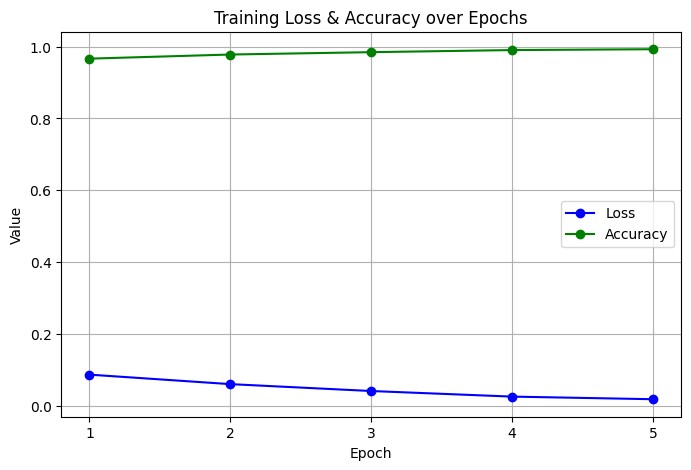

In [ ]:
# 1️⃣ Training Loss & Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o', color='blue', label='Loss')
plt.plot(range(1, num_epochs+1), epoch_accuracies, marker='o', color='green', label='Accuracy')
plt.title("Training Loss & Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(range(1, num_epochs+1))
plt.grid(True)
plt.legend()
plt.show()

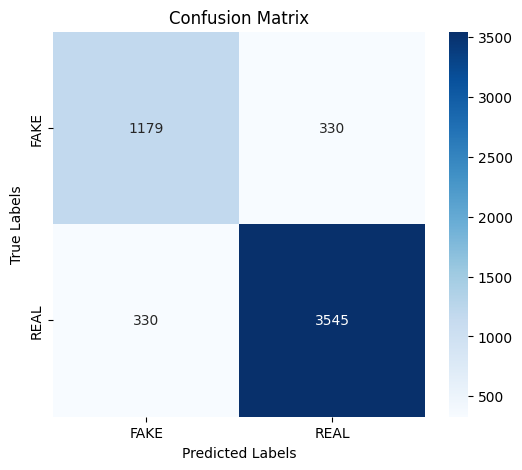

In [ ]:
# 2️⃣ Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

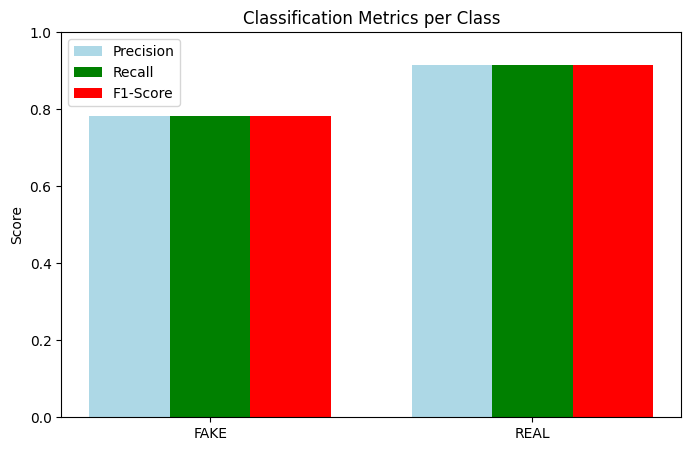

In [ ]:
# 3️⃣ Classification Metrics as Bar Chart
report = classification_report(true_labels, preds, target_names=label_encoder.classes_, output_dict=True)
labels = list(report.keys())[:-3]  # exclude 'accuracy', 'macro avg', 'weighted avg'
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, precision, width, label='Precision', color='lightBlue')
plt.bar(x, recall, width, label='Recall', color='green')
plt.bar(x + width, f1, width, label='F1-Score', color='red')
plt.xticks(x, labels)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Classification Metrics per Class")
plt.legend()
plt.show()

In [ ]:
# =========================
# Prediction Function (REAL / FAKE only)
# =========================
def predict(texts, model, tokenizer, label_encoder, device):
    """
    Predicts whether given text(s) are REAL or FAKE.

    Args:
        texts (str or list of str): Input text(s) to classify.
        model: Trained DistilBERT model.
        tokenizer: Tokenizer used for preprocessing.
        label_encoder: Fitted LabelEncoder to decode predictions.
        device: Torch device (cpu/cuda).

    Returns:
        list of str: Predicted labels (REAL or FAKE).
    """
    if isinstance(texts, str):
        texts = [texts]  # wrap single input into list

    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

    # Convert numeric preds back to labels ("REAL" / "FAKE")
    return label_encoder.inverse_transform(preds).tolist()


In [ ]:
sample_text = "U.S. military airstrike on a drug boat from Venezuela, resulting in 11 deaths, was shared by President Donald Trump and other officials."
result = predict(sample_text, model, tokenizer, label_encoder, device)
print(result)

['FAKE']


In [ ]:
sample_text = "Russia was accused of jamming the GPS of European Commission President Ursula von der Leyen's plane."
result = predict(sample_text, model, tokenizer, label_encoder, device)
print(result)

['FAKE']


In [ ]:
sample_text = "Indian airstrike on Pakistan, and Indian naval forces allegedly attacking Karachi port."
result = predict(sample_text, model, tokenizer, label_encoder, device)
print(result)

['FAKE']


In [ ]:
sample_text = "Yamuna crosses danger mark in Delhi; Severe floods claim 37 lives in Punjab, State government confirms"
result = predict(sample_text, model, tokenizer, label_encoder, device)
print(result)

['REAL']


In [ ]:
sample_text = "IIT-Madras secures top spot in NIRF Rankings 2025 for seventh year in a row"
result = predict(sample_text, model, tokenizer, label_encoder, device)
print(result)

['REAL']


In [ ]:
sample_text = "Centre, Manipur govt, Kuki-Zo groups sign agreement; NH-2 to be opened"
result = predict(sample_text, model, tokenizer, label_encoder, device)
print(result)

['REAL']


In [ ]:
sample_text = "BJP Versus Trinamool After Mamata Banerjee's Dandiya At Kolkata Puja Pandal"
result = predict(sample_text, model, tokenizer, label_encoder, device)
print(result)

['REAL']


In [ ]:
import pickle
import torch

# Save model weights (compressed .pt file)
torch.save(model.state_dict(), "model.pth")

# Save tokenizer (uses Hugging Face's save_pretrained method)
tokenizer.save_pretrained("tokenizer/")

# Save LabelEncoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [ ]:
import torch
import pickle
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.to(device)
model.eval()

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("tokenizer/")

# Load LabelEncoder
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sample_text = "Centre, Manipur govt, Kuki-Zo groups sign agreement; NH-2 to be opened"
result = predict(sample_text, model, tokenizer, label_encoder, device)
print("Prediction:", result)


Prediction: ['REAL']


In [ ]:
import gradio as gr
import torch

# 🔹 Prediction function
def predict(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred_id = torch.argmax(probs, dim=-1).cpu().item()

    return label_encoder.inverse_transform([pred_id])[0]

# 🔹 Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=5, placeholder="Enter news text here..."),
    outputs=gr.Label(),
    title="Fake News Detection 🚨",
    description="Enter a news headline or article to check if it is REAL or FAKE."
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d903ed2c933d945e28.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr

def gradio_predict(text):
    return predict(text, model, tokenizer, label_encoder, device)

iface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=5, placeholder="Enter news text here..."),
    outputs=gr.Label(),
    title="Fake News Detection 🚨",
    description="Enter a news article or headline to check if it is REAL or FAKE."
)

iface.launch(share=True)  # share=True gives you a public link
